# Final Assignment Machine Learning and Deep Learning

*This notebook contains the data loading, preprocessing steps, and implementation of all machine learning algorithms used in the study. Explanations are provided, with a particular focus on CNNs and defense mechanisms. Some notes are inspired by exercise solution guides.*

## Import required packages

In [ ]:
# ----------- pip installs ----------- #
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install prettytable
#!pip install scikit-learn
#!pip install scipy
#!pip install scikeras
#!pip install -q kaggle
#!pip install prettytable
#!pip install pillow
#!pip install tabulate
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
# ----------- imports ----------- #
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import shutil
import json
import time
from tabulate import tabulate
## Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
## Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc


## Load Dataset

In [ ]:
kaggle_api_credentials = {"username":"gretawete","key":"8bbf106a9c8444cba82cc93122f9364b"}

In [ ]:
#Create kaggle directory and writing file
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_api_credentials, f)

In [ ]:
#Download CIFAKE Dataset via kaggle API
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.39GB/s]


In [ ]:
#Unzip files
!unzip cifake-real-and-ai-generated-synthetic-images.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jp

In [ ]:
#Set up folder structure
base_dir = '/content/cifake_dataset'

subdirs = ['train/REAL', 'train/FAKE', 'test/REAL', 'test/FAKE']

for subdir in subdirs:
    os.makedirs(os.path.join(base_dir, subdir), exist_ok=True)

In [ ]:
#Move image files from original download location to defined subfolders
source_directory = {
    'train/REAL': '/content/train/REAL',
    'train/FAKE': '/content/train/FAKE',
    'test/REAL': '/content//test/REAL',
    'test/FAKE': '/content/test/FAKE',
}

for subdirectory, source_dir in source_directory.items():
    for filename in os.listdir(source_dir):
        if filename.endswith('.jpg'):
            source_path = os.path.join(source_dir, filename)
            destination_path = os.path.join(base_dir, subdirectory, filename)
            shutil.move(source_path, destination_path)

In [ ]:
#Define function to count images
def count_images(path):
    count = 0
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                count += 1
    return count

#Test with test fake folder
image_count = count_images('/content/cifake_dataset/test/FAKE')
print("Number of images in FAKE folder:", image_count)

Number of images in FAKE folder: 10000


The following function is inspired from the code used in: https://github.com/ata-turhan/Cifar10-Image-Classification

In [ ]:
#Load data into notebook from directory
def loading_image(folder_path, label_value, set_type, class_type):
    images = [] #list of stored image as np.arrays
    labels = [] #list of labels per image (0 and 1)
    image_identifiers = [] #unique identifier consisting of characteristics (e.g. Real, train, Image name); only used to validate whether loading worked

    if os.path.exists(folder_path):
        file_list = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        for filename in file_list:
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path).convert('RGB').resize((32, 32)) #opens image, converts into RGB format and resizes
                images.append(np.array(img)) #converts image into numpy array and adds it to images list
                labels.append(label_value) #adds corresponding label value to labels list
                identifier = f"{set_type}{class_type}{filename}" #unique identifier for validation purposes
                image_identifiers.append(identifier) #adds identifier to list

            except Exception as e: #error for processing issues
                print(f"Error processing file {filename} in {folder_path}: {e}")
    else: #error for folder issues
        print(f"Folder does not exist: {folder_path}")

    return images, labels, image_identifiers

#Load all data by calling the function
real_train_images, real_train_labels, real_train_ids = loading_image('/content/cifake_dataset/train/REAL', 0, "train", "REAL")
fake_train_images, fake_train_labels, fake_train_ids = loading_image('/content/cifake_dataset/train/FAKE', 1, "train", "FAKE")
real_test_images, real_test_labels, real_test_ids = loading_image('/content/cifake_dataset/test/REAL', 0, "test", "REAL")
fake_test_images, fake_test_labels, fake_test_ids = loading_image('/content/cifake_dataset/test/FAKE', 1, "test", "FAKE")

In [ ]:
#Combine all images (in order to enable unified preprocessing, train/test split is conducted later)
all_images = np.array(real_train_images + fake_train_images + real_test_images + fake_test_images)
all_labels = np.array(real_train_labels + fake_train_labels + real_test_labels + fake_test_labels)
all_identifiers = real_train_ids + fake_train_ids + real_test_ids + fake_test_ids

print(f"Total images: {len(all_images)}")
print(f"Real labels: {np.sum(all_labels == 0)}")
print(f"Fake labels: {np.sum(all_labels == 1)}")

Total images: 120000
Real labels: 60000
Fake labels: 60000


## Image Validation

Label: 0


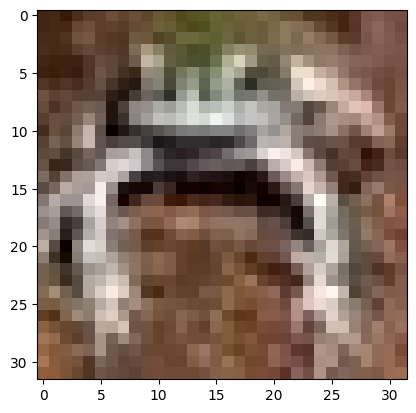

In [ ]:
#Validate image loading based on name and label in REAL folder
real_image = "trainREAL3934 (7).jpg"
index = all_identifiers.index(real_image)
plt.imshow(all_images[index])
print("Label:", all_labels[index])


Label: 1


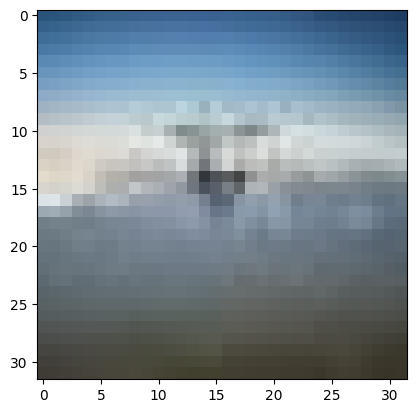

In [ ]:
#Validate image loading based on name and label in FAKE folder
validation_image_fake = "trainFAKE3946.jpg"
index = all_identifiers.index(validation_image_fake)
plt.imshow(all_images[index])
print("Label:", all_labels[index])

## Preprocessing

**Shuffling**

In [ ]:
#Preview order of labels
print("First 500 labels before shuffle:",all_labels[:500])

First 500 labels before shuffle: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
print("Last 500 labels before shuffle:",all_labels[-500:])

Last 500 labels before shuffle: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [ ]:
#Shuffle images to prevent model from bias
all_images, all_labels, all_identifiers = shuffle(all_images, all_labels, all_identifiers, random_state=42)

In [ ]:
#Validate shuffling
print("First 500 labels after shuffle:",all_labels[:500])

First 500 labels after shuffle: [1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 1
 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 0
 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1
 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0
 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0
 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0
 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0
 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0
 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1
 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1
 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0

In [ ]:
print("last 500 labels after shuffle:",all_labels[-500:])

last 500 labels after shuffle: [1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1
 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1
 1 0 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1
 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0
 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0
 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0
 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1
 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0
 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1
 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0
 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 

Index: 82714
Label: 1


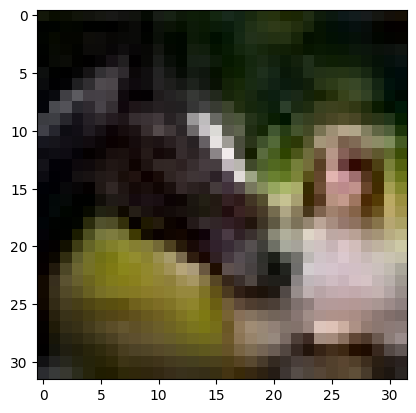

In [ ]:
#Validate that shuffling keeps correct image with correct label
validation_image_fake = "testFAKE776 (8).jpg"
index = all_identifiers.index(validation_image_fake)
print("Index:", index)
plt.imshow(all_images[index])
print("Label:", all_labels[index])

In [ ]:
#Check shape of numpy arrays
all_images.shape, all_images.shape

((120000, 32, 32, 3), (120000, 32, 32, 3))

**Feature Scaling**

In [ ]:
#Scale the image arrays (pixel values normally range from 0 to 255)
all_images = all_images / 255.0

#Print the shape and range of the scaled dataset
print(f"Shape of images: {all_images.shape}")
print(f"Pixel value range: {all_images.min()} to {all_images.max()}")

Shape of images: (120000, 32, 32, 3)
Pixel value range: 0.0 to 1.0


**Duplicates checking**

**Note**: In order to effectively do so the numpy arrays are first flattened and then np.unique is used

In [ ]:
#Flatten the images into 2D array
flattened_images = all_images.reshape(len(all_images), -1)

#Find unique rows and their indices, axis=0 is so that the comparison is done row-wise
unique_images, unique_indices = np.unique(flattened_images, axis=0, return_index=True)

#Create a mapping of unique images to their indices as dictionary
mapping = {tuple(img): [] for img in unique_images}

#Store a list of locations where a specific image is found within the dataset
for idx, img in enumerate(flattened_images):
    mapping[tuple(img)].append(idx)

#Find duplicate pairs by iterating through v<lues of mapping dictionary
duplicate_pairs = []
for indices in mapping.values():
    if len(indices) > 1:  #if more than one index corresponds to the same image, it is a duplicate
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                duplicate_pairs.append((indices[i], indices[j])) #duplicate pairs are added to list

#Print results
print(f"Number of duplicate pairs: {len(duplicate_pairs)}")
print(f"Duplicate pairs: {duplicate_pairs}")

Number of duplicate pairs: 1336
Duplicate pairs: [(18978, 98536), (83188, 105119), (32726, 73996), (74700, 115519), (590, 12182), (12159, 28817), (52653, 104673), (20326, 96556), (80569, 83712), (84999, 118268), (8907, 87492), (16380, 116990), (3483, 42450), (35515, 65225), (23181, 58364), (15825, 92625), (44891, 109004), (69696, 113731), (26212, 34419), (35970, 69150), (8278, 49999), (36217, 76519), (12980, 34519), (731, 39484), (62558, 118535), (20308, 55663), (2692, 102792), (26981, 29837), (39043, 103371), (4029, 116288), (1944, 36065), (83381, 105057), (39861, 68299), (31309, 57576), (29299, 103081), (66653, 74146), (17343, 17450), (53270, 66107), (27585, 63589), (25364, 34719), (18774, 113438), (47475, 53080), (69174, 117016), (381, 118890), (62947, 89197), (62012, 111946), (2018, 117339), (45011, 107858), (38403, 63406), (15694, 83100), (28537, 40142), (67449, 81100), (57710, 90552), (28077, 118286), (1971, 58188), (34032, 79370), (71042, 84490), (24048, 98605), (49878, 85793), 

**Note**: In order to find out whether the duplicates correspond to the fake or real set, the labels are mapped to the duplicate indices

In [ ]:
#Map duplicate indices to their corresponding labels
duplicate_classes = [(all_labels[i], all_labels[j]) for i, j in duplicate_pairs]

#Initialize counts for real and fake duplicates
real_duplicates = 0
fake_duplicates = 0

#Iterate through duplicate classes and count
for label1, label2 in duplicate_classes:
    if label1 == 0 and label2 == 0:  #both images are real
        real_duplicates += 1
    elif label1 == 1 and label2 == 1:  #both images are fake
        fake_duplicates += 1

#Print results
print(f"No. of real duplicates: {real_duplicates}")
print(f"No. of fake duplicates: {fake_duplicates}")

No. of real duplicates: 0
No. of fake duplicates: 1336


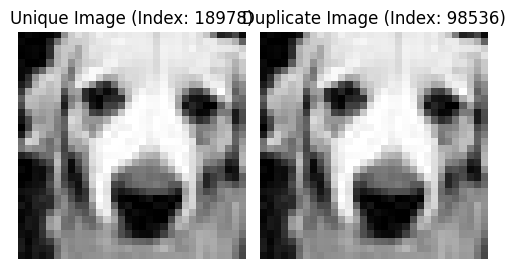

In [ ]:
#Plot unique and duplicate image to validate
for unique_idx, duplicate_idx in duplicate_pairs[:1]:
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    #Plot the unique image
    axes[0].imshow(all_images[unique_idx])
    axes[0].set_title(f"Unique Image (Index: {unique_idx})")
    axes[0].axis('off')

    #Plot the duplicate image
    axes[1].imshow(all_images[duplicate_idx])
    axes[1].set_title(f"Duplicate Image (Index: {duplicate_idx})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
#Keep only the unique images, labels and identifiers
all_images = all_images[unique_indices]
all_labels = all_labels[unique_indices]
all_identifiers = [all_identifiers[i] for i in unique_indices]
print(f"Number of unique images: {len(all_images)}")

Number of unique images: 118664


## EDA

Check **class balance** after removal of duplicates

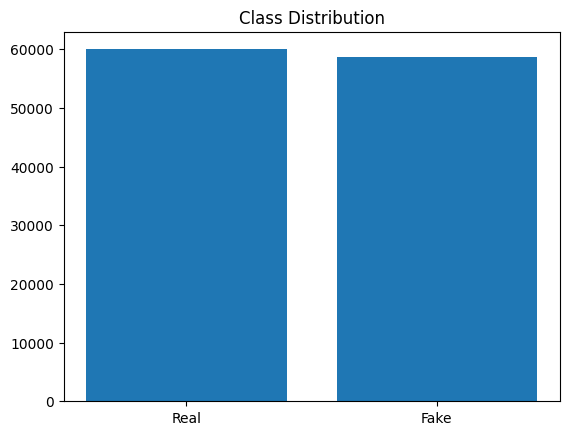

In [ ]:
#Count occurrences of unique labels
real_count = np.sum(all_labels == 0)
fake_count = np.sum(all_labels == 1)
#Plot the distribution
plt.bar([0, 1], [real_count, fake_count], tick_label=["Real", "Fake"])
plt.title("Class Distribution")
plt.show()

**Pixel Value Distribution**

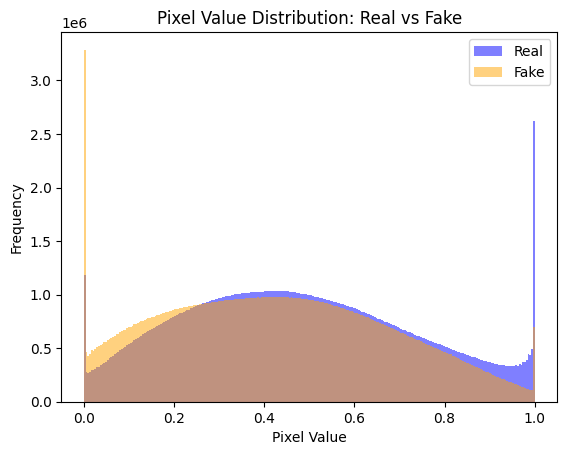

In [ ]:
#Separate pixel values for real and fake images and flatten
real_pixel_values = all_images[all_labels == 0].flatten()
fake_pixel_values = all_images[all_labels == 1].flatten()

#Plot histograms for real and fake pixel distributions, bins = 255 as pixels were initially in that range
plt.hist(real_pixel_values, bins=255, color='blue', alpha=0.5, label='Real')
plt.hist(fake_pixel_values, bins=255, color='orange', alpha=0.5, label='Fake')
plt.title("Pixel Value Distribution: Real vs Fake")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**Shape consistency and brightness**

In [ ]:
#Check if all images have the correct shape
expected_shape = (32, 32, 3)
bad_shapes = []
for x in range(len(all_images)):
    if all_images[x].shape != expected_shape:
        bad_shapes.append(x)

print("Number of images with wrong shape:", len(bad_shapes))

Found 0 images with unexpected shape.


In [ ]:
#Check if each image has the same color in all pixels
constant_images = []

for x in range(len(all_images)):
    img = all_images[x]
    if np.all(img == img[0, 0, :]):  #compare all pixels to the top-left pixel
        constant_images.append(x)

print("Number of constant-color images:", len(constant_images))

Found 0 constant-color images.


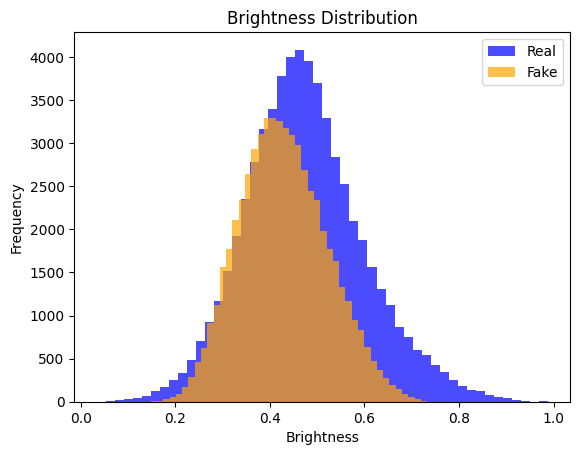

In [ ]:
# Check distribution of brightness values to see if the distribution is normal
real_brightness_values = np.mean(all_images[all_labels == 0], axis=(1, 2, 3))
fake_brightness_values = np.mean(all_images[all_labels == 1], axis=(1, 2, 3))

plt.hist(real_brightness_values, bins=50, color='blue', alpha=0.7)
plt.hist(fake_brightness_values, bins=50, color='orange', alpha=0.7)
plt.title("Brightness Distribution")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.legend(['Real', 'Fake'])
plt.show()


**Plot exemplary images per class**

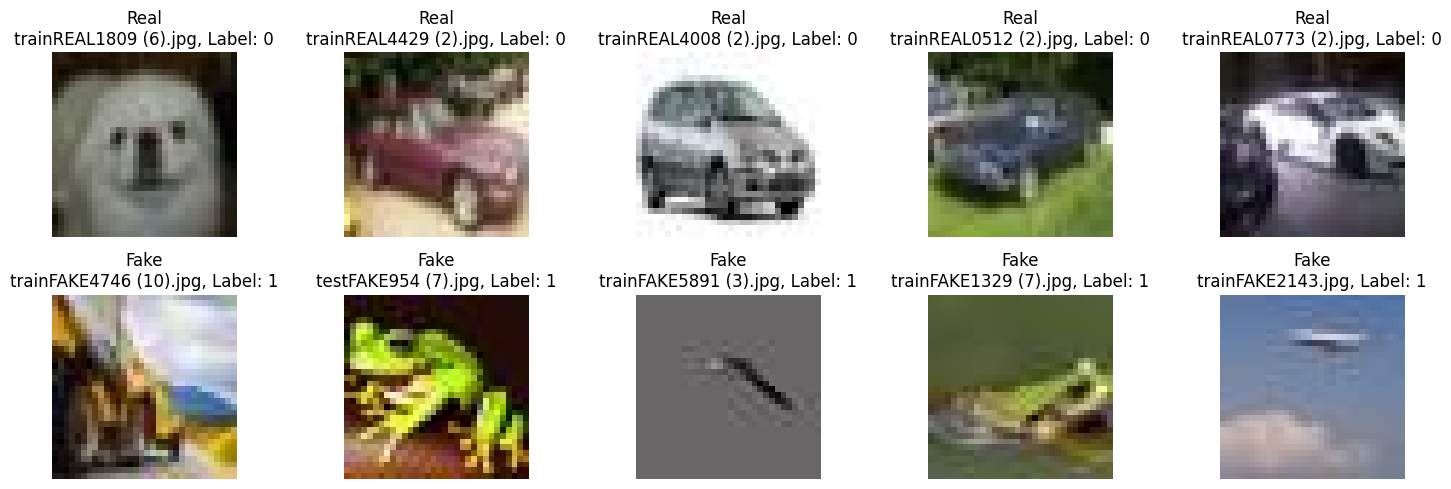

In [ ]:
#Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

#Get indices of real and fake images
real_indices = [i for i, label in enumerate(all_labels) if label == 0]
fake_indices = [i for i, label in enumerate(all_labels) if label == 1]

# Plot real images (top row)
chosen_real_indices = random.sample(real_indices, 5)
for ax, idx in zip(axes[0], chosen_real_indices):
    ax.imshow(all_images[idx])
    ax.axis('off')
    ax.set_title(f"Real\n{all_identifiers[idx]}, Label: {all_labels[idx]}")

# Plot fake images (bottom row)
chosen_fake_indices = random.sample(fake_indices, 5)
for ax, idx in zip(axes[1], chosen_fake_indices):
    ax.imshow(all_images[idx])
    ax.axis('off')
    ax.set_title(f"Fake\n{all_identifiers[idx]}, Label: {all_labels[idx]}")

plt.tight_layout()
plt.show()

## Split Training, Testing and Validation Data

In [ ]:
#Split 70% train, 30% test
train_images_full, test_images, train_labels_full, test_labels = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42)

#Create validation data (20% from training data)
train_images, val_images, train_labels, val_labels = train_test_split(train_images_full, train_labels_full, test_size=0.2, stratify=train_labels_full, random_state=42)

print(f"Train images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Train images: 66451
Validation images: 16613
Test images: 35600


## CNN Models 1-4

**CNN 1:** Initial Model with 3 convolutional layers, 2 MaxPooling layers, one flatten layer and finally 2 dense layers.

Find below a detailed description of each layer of the network. For the following CNN models, only the changes compared to the previous model will be pointed out.

1. First Conv2D Layer
*   output shape: (None, 32, 32, 32)
*   32 filters and 896 trainable parameters
This layer scans the input image with 32 distinct filters of size 3x3, using ReLU activation and padding. The strides element ensures that no pixel is skipped when the filter processes the image. The 896 parameters consist of weights and biases that govern how each filter extracts basic features from the image like edges and textures.

2. First MaxPooling2D Layer
*   Output shape: (None, 16, 16, 32)
*   0 parameters
This layer reduces the spatial dimensions of the first convolutional layer by taking the maximum from from each non-overlapping block (2x2 as specified). This layer thus takes the most significant features, reduces the spatial dimensions by half while keeping 32 feature maps. It thereby reduces computational complexity of the model.

3. Second Conv2D Layer
*   output shape: (None, 16, 16, 64)
*   18,496 parameters
With 64 filters and the size 3x3, this layer extracts more complex patterns from the pooled feature map as input. The output shape has the same spatial dimensions while increasing depth to 64 channels, reflecting richer set of features captured by 18,496 parameters.

4. Second MaxPooling2D layer
*   output shape: (None, 8, 8, 64)
*   0 parameters
Just like the first max pooling layer, this reduces the spatial dimensions from the second convolutional layer from 16x16 to 8x8 while maintaining the 64 channels.

5. Third convolutional layer
*   Output shape: (None, 8, 8, 128)
*   parameters: 73,856
This convolutional layer applies 128 filters of size 3x3, again keeping the same padding, strides and activation function. By doing so, this layer dives into more intricate and abstract feature extraction. The output maintains the same spatial dimensions while showing increased depth of 128 channels defined by 73,856 parameters. This captures the most complex features of our images.

Note: because the spatial dimensions 8x8 is rather small, we decided not to include another pooling layer before flattening the data .

6. Flatten Layer
*   output shape: (None, 8192)
*   parameters: 0
This layer converts multi-dimensional feature maps (8x8x128) into one-dimensional vector of 8192 elements to use as input for dense layers.

7. First Dense Layer
*   Output shape: (None, 128)
*   Parameters: 1,048,704
This layer ransforms the 8192-vector into 128-feature vector. To do so, the fully connected dense layer learns from combinations of features and defines the 1,048,704 parameters (they stem from the dense connection between flattened input and the 128 neurons)

8. Final Dense Layer
*   Output shape: (None, 1)
*   parameters: 129
The final layer produces 1 output corresponding to the probability of an image to belong to the real or the fake class. For the first time in the network, sigmoid is used as the activation function (rather than relu) to turn the outcome of the network into a binary classification. The 129 parameters map the 128 features to this outcome probability.















In [ ]:
#Setup model structure
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1, input_shape=(32, 32, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1))
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Compile the model
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Fit the model
history = model1.fit(train_images, train_labels, epochs=15, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8251 - loss: 0.3745 - val_accuracy: 0.9152 - val_loss: 0.2093
Epoch 2/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9186 - loss: 0.2038 - val_accuracy: 0.9330 - val_loss: 0.1769
Epoch 3/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9322 - loss: 0.1705 - val_accuracy: 0.9359 - val_loss: 0.1656
Epoch 4/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9443 - loss: 0.1419 - val_accuracy: 0.9295 - val_loss: 0.1791
Epoch 5/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9521 - loss: 0.1216 - val_accuracy: 0.9416 - val_loss: 0.1518
Epoch 6/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9631 - loss: 0.0977 - val_accuracy: 0.9440 - val_loss: 0.1461
Epoch 7/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9709 - loss: 0.0752 - val_accuracy: 0.9379 - val_loss: 0.1795
Epoch 8/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9745 - loss: 0.0641 -

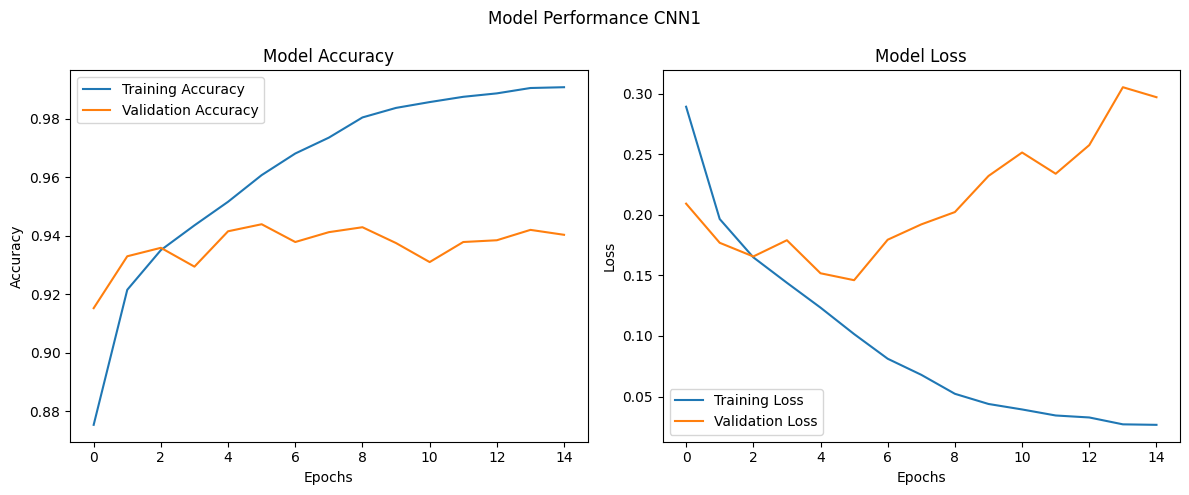

In [ ]:
#Plot learning curves
plt.figure(figsize=(12, 5))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Model Performance CNN1')

plt.tight_layout()

In [ ]:
#Evaluate model performance
model1.evaluate(test_images, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9426 - loss: 0.2966


[0.2999839186668396, 0.941657304763794]

-> Based on the learning curves, model 1 is overfitting. This is why added dropout in the next model

**CNN 2:** second CNN with 3 convolutional layers, 2 MaxPooling layers, 2 one flatten, two dense and one dropout layer.

*Changes to previous model:*
Include a dropout layer between the two dense layers to address the problem of overfitting. We only add one dropout layer but set the dropout rate to 0.5 (so quite high). This means, the dropout layer randomly disables half of the previous layer's neurons for the final dense layer during training.

In [ ]:
#Setup model structure
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1, input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5)) #Introduction of dropout layer
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Compile the model
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Fit the model
history = model2.fit(train_images, train_labels, epochs=15, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7959 - loss: 0.4163 - val_accuracy: 0.9148 - val_loss: 0.2190
Epoch 2/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9095 - loss: 0.2318 - val_accuracy: 0.9254 - val_loss: 0.1918
Epoch 3/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9227 - loss: 0.2000 - val_accuracy: 0.9364 - val_loss: 0.1653
Epoch 4/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9330 - loss: 0.1747 - val_accuracy: 0.9371 - val_loss: 0.1638
Epoch 5/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9417 - loss: 0.1505 - val_accuracy: 0.9369 - val_loss: 0.1641
Epoch 6/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9472 - loss: 0.1359 - val_accuracy: 0.9430 - val_loss: 0.1544
Epoch 7/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9532 - loss: 0.1199 - val_accuracy: 0.9431 - val_loss: 0.1553
Epoch 8/15
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9579 - loss: 0.1101 -

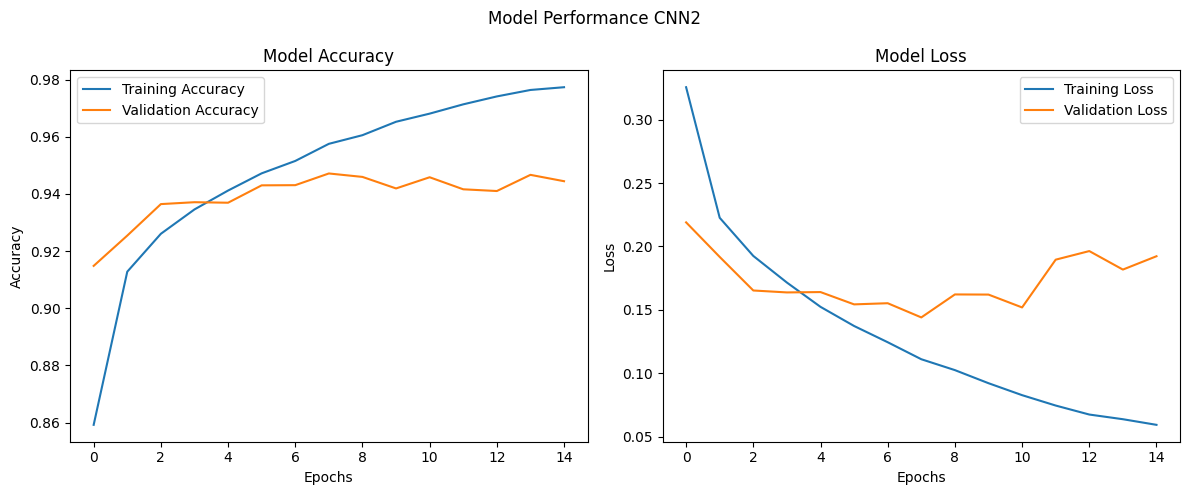

In [ ]:
#Plot learning curves
plt.figure(figsize=(12, 5))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Model Performance CNN2')
plt.tight_layout()
plt.show()

In [ ]:
#Evaluate model performance
model2.evaluate(test_images, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9433 - loss: 0.1944


[0.19294418394565582, 0.9435393214225769]

-> Model 2 is still overfitting, so we introduce additional measures to prevent overfitting: L2 regularizers.

**CNN 3:** CNN with 3 convolutional layers, 2 MaxPooling layers, 2 one flatten, two dense, one dropout layer and added L2 regularization with lambda = 0.01

*Changes to previous model:*
Because we are still observing overfitting, we introduce L2 regularization at a lambda rate of 0.01 at each convolutional layer as well as at the first dense layer. It adds penalty on the size of models parameters, forcing the model to keep weights small (but not setting weights equal to 0). We also increased the number of epochs to 30, to understand how the model behaves over longer training period.

In [ ]:
#Setup model structure
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.01), input_shape=(32, 32, 3))) #introduction of L2 regularization
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.01)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.01)))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Compile the model
model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Fit the model
history = model3.fit(train_images, train_labels, epochs=30, batch_size=32, #increase number of epochs
                     validation_data=(val_images, val_labels))

Epoch 1/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7292 - loss: 0.7565 - val_accuracy: 0.8136 - val_loss: 0.4869
Epoch 2/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8174 - loss: 0.4843 - val_accuracy: 0.8276 - val_loss: 0.4622
Epoch 3/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8311 - loss: 0.4597 - val_accuracy: 0.8410 - val_loss: 0.4400
Epoch 4/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8471 - loss: 0.4388 - val_accuracy: 0.8600 - val_loss: 0.4081
Epoch 5/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8593 - loss: 0.4176 - val_accuracy: 0.8800 - val_loss: 0.3813
Epoch 6/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8637 - loss: 0.4059 - val_accuracy: 0.8640 - val_loss: 0.4057
Epoch 7/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8700 - loss: 0.3915 - val_accuracy: 0.8823 - val_loss: 0.3714
Epoch 8/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8746 - loss: 0.3843 -

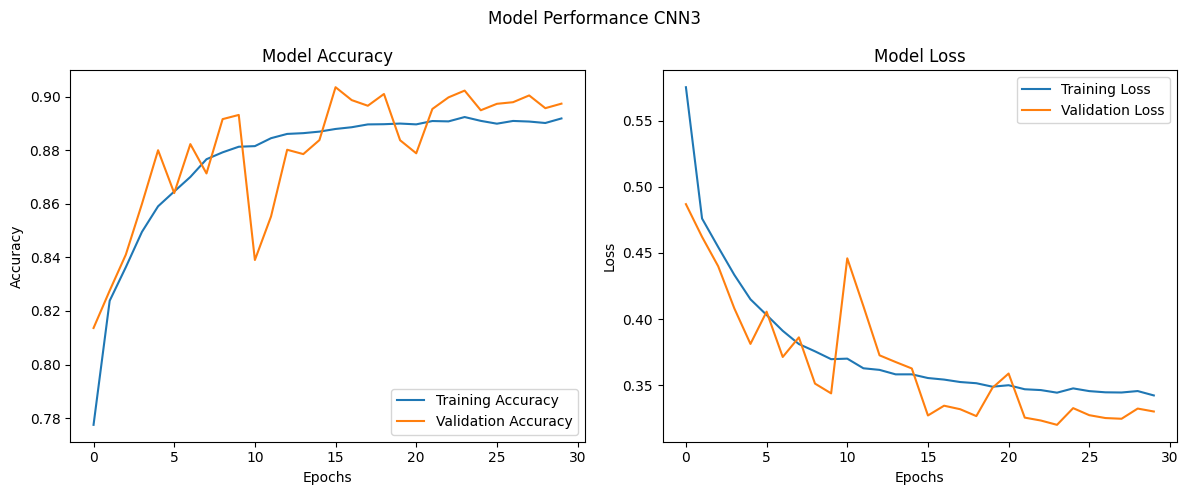

In [ ]:
#Plot learning curves
plt.figure(figsize=(12, 5))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Model Performance CNN3')

plt.tight_layout()
plt.show()

In [ ]:
#Evaluate model performance
model3.evaluate(test_images, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8961 - loss: 0.3299


[0.32784515619277954, 0.8970224857330322]

-> Model does not overfit anymore, but underfits slightly (as validation accuracy is mostly higher than training accuracy) and overall accuracy decreased. So we decrease the regularization rate (lambda = 0.001) and add one convolutional layer.

**CNN 4:** CNN with 4 convolutional layers, 3 MaxPooling layers, one flatten, two dense, one dropout layer and L2 regularization with lambda = 0.001.

*Changes to previous model:*
We decrease the regularization rate to 0.001 (compared to 0.01 in the previous CNN). This is because while addressing the issue of overfitting, adding the regularization rate also decreased accuracy. To make the model more accurate again, we decrease the regularization rate and add one additional convolutional layer with 64 filters of size 3x3 to capture more patterns of the images.

In [ ]:
#Setup model structure
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1,kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3))) #decrease regularization rate
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001))) #addition of one conv. layer
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Compile the model
model4.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Fit the model
history = model4.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_images, val_labels),
)

Epoch 1/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7959 - loss: 0.5241 - val_accuracy: 0.8904 - val_loss: 0.3243
Epoch 2/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8915 - loss: 0.3274 - val_accuracy: 0.9100 - val_loss: 0.2851
Epoch 3/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9061 - loss: 0.2963 - val_accuracy: 0.9140 - val_loss: 0.2795
Epoch 4/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9163 - loss: 0.2783 - val_accuracy: 0.9100 - val_loss: 0.2841
Epoch 5/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9222 - loss: 0.2621 - val_accuracy: 0.9281 - val_loss: 0.2380
Epoch 6/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9226 - loss: 0.2603 - val_accuracy: 0.9293 - val_loss: 0.2385
Epoch 7/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9232 - loss: 0.2541 - val_accuracy: 0.9290 - val_loss: 0.2380
Epoch 8/30
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9281 - loss: 0.2456 -

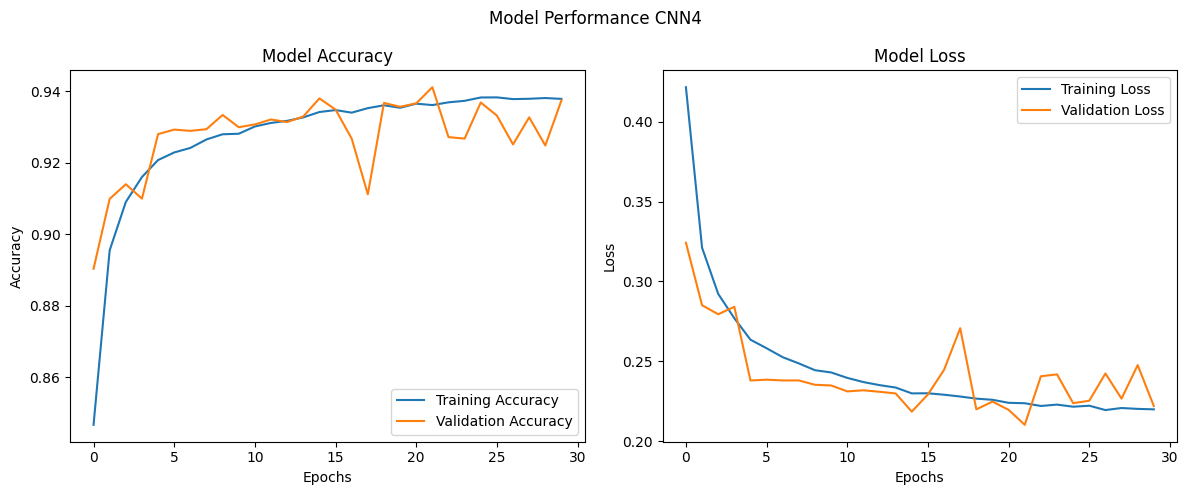

In [ ]:
#Plot learning curves
plt.figure(figsize=(12, 5))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Model Performance CNN4')
plt.tight_layout()
plt.show()

In [ ]:
#Evaluate model performance
model4.evaluate(test_images, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9350 - loss: 0.2295


[0.2261274755001068, 0.9359550476074219]

-> Accuracy increased and no overfitting visible so tuning of hyperparameters learning rate and batch size to further optimize the model

## Random Search
After structural optimizations of the model, parameters will now be tuned using Random Search Tuner from Keras.
Parameters adjusted: batch size, learning rate
Code inspired by: https://keras.io/keras_tuner/api/tuners/random/ & https://stackoverflow.com/questions/76109047/integrate-batch-size-in-keras-tuner

**Note**: We introduce early stopping as a regularization technique that stops the training process if the validation loss does not decrease for 3 epochs in a row. That way, we stop overfitting early, saving some computational capacity while allowing the model to train for longer if necessary.

In [ ]:
#Define EarlyStopping to prevent overfitting and save comp. power
#Stops training when validation loss hasn't improved for 3 epochs and restores the weights from the best epoch
early_stoppingrs = EarlyStopping(
    monitor='val_loss', #Monitor validation loss
    patience=3, #Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True #Restore model weights from the epoch with the best value of the monitored quantity
)

#Model building function to fit our model using Kerass tuner
class Optimizer(kt.HyperModel):
  def build(self, hp):
    model = models.Sequential()
    #Hyperparameters
    #Define Learning rate
    learning_rate = hp.Float("learning_rate", min_value=0.0001, max_value=0.01, sampling="log")
    #Define Batch size
    hp.Int("batch_size", min_value=8, max_value=32, step=8)

    #Build model setup like CNN 4 with regularization
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1,kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    #Compile and training model based on learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

  #Override default fit() method from Keras Tuner to tune training-related parameters (like batch size here)
  def fit(self, hp, model, *args, **kwargs):
    batch_size = hp.get("batch_size") #Retrieves value from defined batch size above
    return model.fit(*args, batch_size=batch_size, **kwargs) #Calls fit method to train it, *args and**kwargs are passed through (e.g. epochs, validation data etc.)

#Set up a Keras Tuner random search to find best hyperparameters
tuner = kt.RandomSearch(
    Optimizer(),       #Hypermodel class
    objective="val_loss", #Minimize validation loss
    max_trials=10,    #Try 10 different hyperparameter combinations
    executions_per_trial=1,   #Run reach trial once
    directory="cnn_random_search",  #Folder to store tuner output
    overwrite=True,     #Overwrite previous runs
    project_name="cnn_random_search2"
)

#Start the hyperparameter search
start_time = time.time()

#Perform actual hyperparameter search
tuner.search(train_images, train_labels, epochs=50, validation_data=(val_images, val_labels), callbacks=[early_stoppingrs])

end_time = time.time()

#Calculate and print running time
total_time = end_time - start_time
print(f"Random Search Running Time: {total_time:.4f} seconds")

#Retrieve the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

#Display best hyperparameters
print("Best hyperparameters:")
print(f"Learning Rate: {best_hp.get('learning_rate')}")
print(f"Batch Size: {best_hp.get('batch_size')}")

Trial 10 Complete [00h 02m 01s]
val_loss: 0.23685386776924133

Best val_loss So Far: 0.18520806729793549
Total elapsed time: 00h 23m 23s
Random Search Running Time: 1403.2324 seconds
Best hyperparameters:
Learning Rate: 0.00034433837617914396
Batch Size: 8


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## CNN 5

**CNN 5:** CNN with 4 convolutional layers, 3 MaxPooling layers, one flatten, two dense, one dropout layer and L2 regularization with lambda = 0.001, batch size=8, Learning Rate of: 0.00034433837617914396 (Random Search), Early Stopping with Patience=5

*Changes to previous model:*
Adjusted learning rate & batch size from Random Search, increase patience in early stopping from 3 (in Random Search) to 5 to not risk stopping too early and missing later improvement

In [ ]:
#Set up model structure
model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1,kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model5.add(layers.Flatten())
model5.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Compile model
model5.compile(optimizer=keras.optimizers.Adam(learning_rate=(0.00034433837617914396)), #Learning rate from Random Search
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stoppingcnn5 = EarlyStopping(
    monitor='val_loss',  #Monitor validation loss
    patience=5,          #Change from 3 to 5
    restore_best_weights=True  #Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
start_timeCNN = time.time()
history = model5.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=8,
    validation_data=(val_images, val_labels),
    callbacks=[early_stoppingcnn5]  #Add early stopping
)
end_timeCNN = time.time()
cnn_time = end_timeCNN - start_timeCNN

Epoch 1/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.8179 - loss: 0.5092 - val_accuracy: 0.8963 - val_loss: 0.3178
Epoch 2/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9039 - loss: 0.3094 - val_accuracy: 0.9083 - val_loss: 0.2868
Epoch 3/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9123 - loss: 0.2831 - val_accuracy: 0.9251 - val_loss: 0.2523
Epoch 4/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9218 - loss: 0.2613 - val_accuracy: 0.9262 - val_loss: 0.2431
Epoch 5/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9247 - loss: 0.2512 - val_accuracy: 0.9350 - val_loss: 0.2279
Epoch 6/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9280 - loss: 0.2411 - val_accuracy: 0.9245 - val_loss: 0.2444
Epoch 7/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9294 - loss: 0.2388 - val_accuracy: 0.9323 - val_loss: 0.2276
Epoch 8/50
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9326 - loss: 0

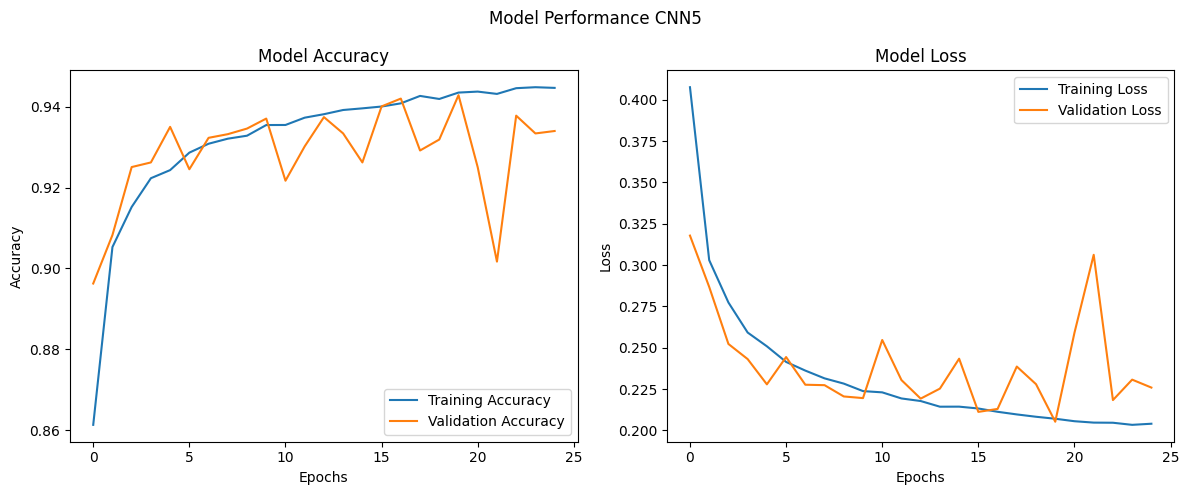

In [ ]:
plt.figure(figsize=(12, 5))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Model Performance CNN5')

plt.tight_layout()
plt.show()

In [ ]:
#Evaluate model performance
optimized_model_performance = model5.evaluate(test_images, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9432 - loss: 0.2103


**Takeaway**: Slightly improved accuracy, however fluctuations in accuracy and loss visible

*Fluctuations can happen for several reasons like data variability or the defined learning rate (if slightly too high, it can cuase model weights to oscillate around good solution)*

## Final CNN Model

**CNN 6:** CNN with 4 convolutional layers, 3 MaxPooling layers, one flatten, two dense, one dropout layer and L2 regularization with lambda = 0.001, batch size=8, Learning Rate of: 0.0001, Early Stopping

*Changes to previous model:*
The value identified was 0.0003, which is already near the lower end of the search range. But since Random Search explores values randomly, it may not have tested values lower than this. To check whether an even smaller learning rate could give better results, we manually try 0.0001, the lowest value in the original range.

In [ ]:
#Set up model
model6 = models.Sequential()
model6.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1,kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model6.add(layers.MaxPooling2D((2, 2)))
model6.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1, kernel_regularizer=regularizers.l2(0.001)))
model6.add(layers.Flatten())
model6.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model6.add(layers.Dropout(0.5))
model6.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Compile the final model
model6.compile(optimizer=keras.optimizers.Adam(learning_rate=(0.0001)), #Adjusted learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Fit the final model
start_timeCNN = time.time()
history = model6.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=8,
    validation_data=(val_images, val_labels),
    callbacks=[early_stoppingcnn5]
)
end_timeCNN = time.time()
cnn_time = end_timeCNN - start_timeCNN

Epoch 1/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.7891 - loss: 0.6336 - val_accuracy: 0.8840 - val_loss: 0.3878
Epoch 2/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.8909 - loss: 0.3651 - val_accuracy: 0.9083 - val_loss: 0.3099
Epoch 3/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9107 - loss: 0.3101 - val_accuracy: 0.8931 - val_loss: 0.3250
Epoch 4/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9194 - loss: 0.2846 - val_accuracy: 0.9093 - val_loss: 0.2866
Epoch 5/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9251 - loss: 0.2655 - val_accuracy: 0.9307 - val_loss: 0.2510
Epoch 6/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9305 - loss: 0.2492 - val_accuracy: 0.9230 - val_loss: 0.2555
Epoch 7/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.9341 - loss: 0.2403 - val_accuracy: 0.9352 - val_loss: 0.2286
Epoch 8/30
8307/8307 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9362 - loss: 0

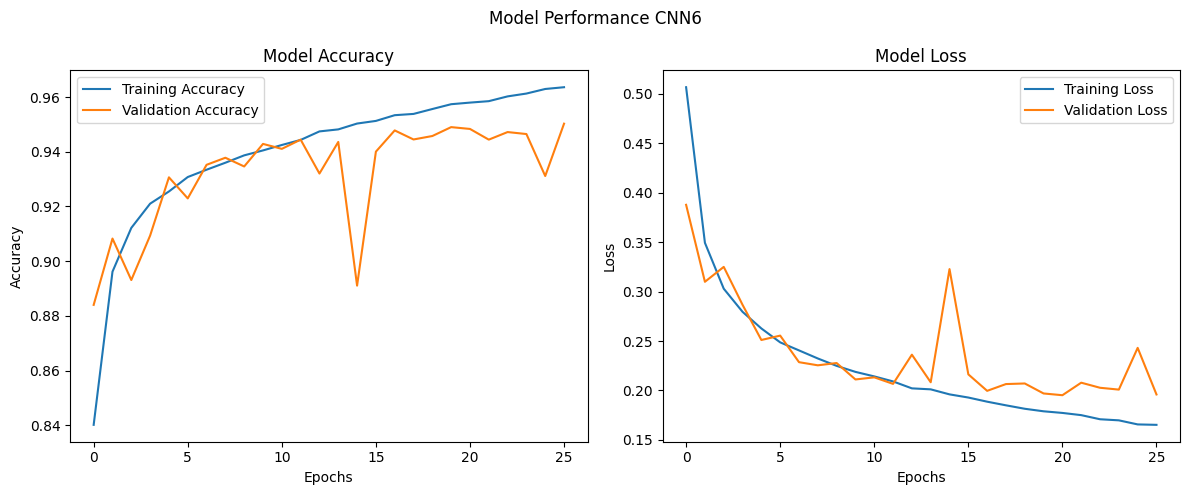

In [ ]:
plt.figure(figsize=(12, 5))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Model Performance CNN6')

plt.tight_layout()
plt.show()

In [ ]:
#Evaluate model performance
optimized_model_performance = model6.evaluate(test_images, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9478 - loss: 0.1984


**Takeaway**: Improved model performance with lower learning rate, similar (low) degree of overfitting

### Get more detailed Performance metrics for final model
Specific focus on Recall (i.e., catching as many fake images as possible)

In [ ]:
#Get predicted probabilities
y_pred_probs_6 = model6.predict(test_images)

#Convert probabilities to class labels
y_pred_6 = (y_pred_probs_6 > 0.5).astype("int32")

#Compute recall for later comparison
cnn6_recall=recall_score(test_labels, y_pred_6)

#Compute Confusion Matrix
cm_6 = confusion_matrix(test_labels, y_pred_6)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


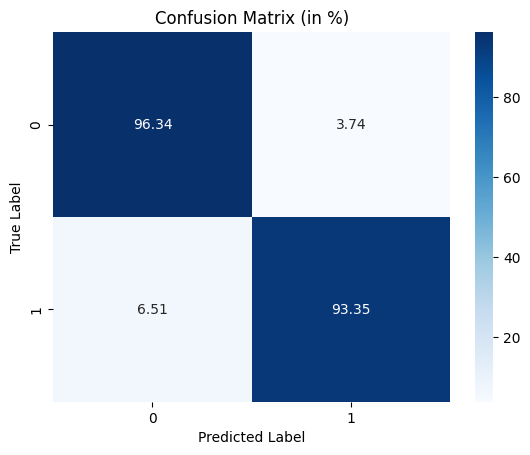

In [ ]:
#Plot Confuciosn Matrix
cm_6 = cm_6 / cm_6.astype(float).sum(axis=1) * 100
sns.heatmap(cm_6, annot=True, fmt=".2f", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (in %)')
plt.show()

## Accuracy and Recall Comparison across CNN models

In [ ]:
#Initiate models and table
models = [model1, model2, model3, model4, model5, model6]
table = []

#Loop over model in list and calculate accuracy, recall
for i, model in enumerate(models, start=1):
    y_pred_probs = model.predict(test_images) #get model predictions
    y_pred = (y_pred_probs > 0.5).astype("int32")
    accuracy = accuracy_score(test_labels, y_pred) #get accuracy score
    recall = recall_score(test_labels, y_pred) #get recall score
    table.append([f"Model {i}", f"{accuracy:.4f}", f"{recall:.4f}"])

#Print formatted table
headers = ["Model", "Accuracy", "Recall"]
print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
╒═════════╤════════════╤══════════╕
│ Model   │   Accuracy │   Recall │
╞═════════╪════════════╪══════════╡
│ Model 1 │     0.9417 │   0.9411 │
├─────────┼────────────┼──────────┤
│ Model 2 │     0.9435 │   0.9297 │
├─────────┼────────────┼──────────┤
│ Model 3 │     0.897  │   0.8974 │
├─────────┼────────────┼──────────┤
│ Model 4 │     0.936  │   0.9218 │
├─────────┼────────────┼──────────┤
│ Model 5 │     0.9422 │   0.9285 │
├─────────┼────────────┼──────────┤
│ Model 6 │     0.9486 │   0.9335 │
╘═════════╧════════════╧══════════╛


## Perform Adversarial Attack using FGSM

1. Takes the input images and the gradients of the loss function with respect to the input, extracted from the  CNN.
2. *Then* perturbs the input image in the direction that maximizes the model’s prediction error.



In [ ]:
#Define function to generate adversarial examples
def generate_adversarial_examples(model, images, labels, epsilon, batch_size=32):
    num_samples = images.shape[0] #start with first test image
    adversarial_images = [] #initiate list for adversarial images

    #Process images in batches to reduce memory usage
    for i in range(0, num_samples, batch_size):
        #Select a batch of images and corresponding labels
        batch_images = images[i:min(i + batch_size, num_samples)]
        batch_labels = labels[i:min(i + batch_size, num_samples)]

        #Convert batch images and labels to tensors for use with tensorflow
        images_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        labels_tensor = tf.convert_to_tensor(batch_labels, dtype=tf.float32)

        #Compute gradients of the loss  w.r.t. to the input images
        with tf.GradientTape() as tape:
            #Mark input images as watchable, so gradients can be computed for them
            tape.watch(images_tensor)
            #Run the model on the batch to get predictions
            predictions = model(images_tensor)
            # Compute the loss between the predictions and the true labels
            loss = tf.keras.losses.binary_crossentropy(tf.expand_dims(labels_tensor, axis=-1), predictions) #ensure label shape matches the predictions

        #Calculate the gradient of the loss with respect to the input images
        gradients = tape.gradient(loss, images_tensor)
        #Create adversarial examples by adding a small step in the direction of the gradient sign
        adversarial_batch = images_tensor + epsilon * tf.sign(gradients)
        #Clip values to stay within the valid image range [0, 1]
        adversarial_batch = tf.clip_by_value(adversarial_batch, 0.0, 1.0)
        #Convert the adversarial batch to NumPy and store it
        adversarial_images.extend(adversarial_batch.numpy()) #Append adversarial images to list
    #Return all the adversarial images as a single NumPy array
    return np.array(adversarial_images)


**Effect of Different Epsilon Values on a Single Image**

To get a feeling for the **visible** impact of the epsilon value, we plot an image with different epsilon values.

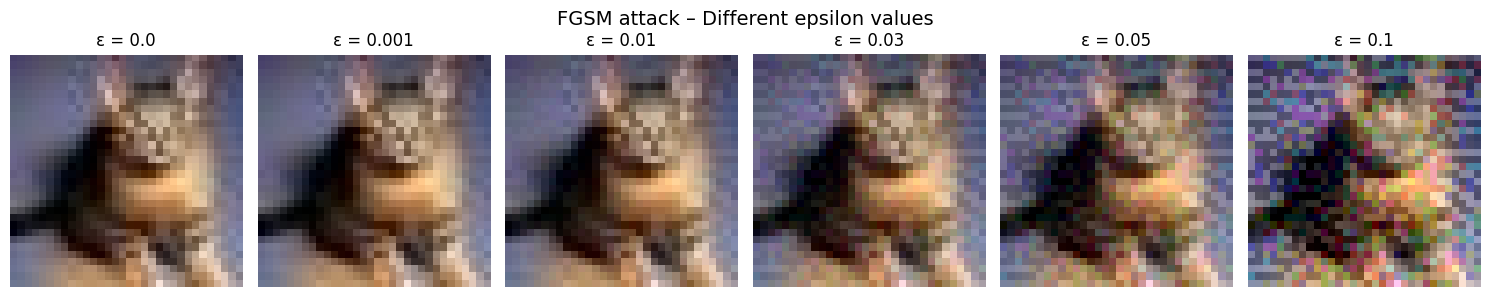

In [ ]:
#Pick image to test
img_index = 2
original_image = test_images[img_index:img_index+1]  #Make it to format necessary for passing it into model: from shape: shape (32, 32, 3) to shape (1, 32, 32, 3) as batch=1
label = test_labels[img_index:img_index+1] #Make it to format necessary for passing it into model: from shape () to (1,)

#Epsilon values to try
epsilons = [0.0, 0.001, 0.01, 0.03, 0.05, 0.1]

#Dictionary to keep adversarial images for each epsilon
adv_images = {}

#Create adversarial image for each epsilon
for eps in epsilons:
    adv = generate_adversarial_examples(model=model6, images=original_image, labels=label, epsilon=eps, batch_size=1)
    adv_images[f"ε = {eps}"] = adv[0]  #Take first image from batch

#Show all images
plt.figure(figsize=(15, 3))
for i, (label, img) in enumerate(adv_images.items()):
    plt.subplot(1, len(adv_images), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.suptitle("FGSM attack – Different epsilon values", fontsize=14)
plt.tight_layout()
plt.show()

Note: After checking the depicted images with varying degrees of epsilon, we selected ϵ = 0.01 as the perturbation size for the adversarial attack. Starting from the most left picture, it is the last picture where changes to the image are still impercetible to the human eye.

In [ ]:
#Set epsilon value
epsilon = 0.01

#Generate adversarial examples for the test images
adversarial_test_images = generate_adversarial_examples(model6, test_images, test_labels, epsilon)

#Generate adversarial examples for the training images
adversarial_train_images = generate_adversarial_examples(model6, train_images, train_labels, epsilon)

#Generate adversarial examples for the validation images
adversarial_val_images = generate_adversarial_examples(model6, val_images, val_labels, epsilon)

print("Adversarial examples generated successfully!")

Adversarial examples generated successfully!


In [ ]:
#Run model on adversarial images
performance_baseline=model6.evaluate(adversarial_test_images, test_labels)


1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6269 - loss: 1.0799


**Takeaway**: strong decline in performance compared to initial model accuracy, already small epsilon of 0.01 sifnigicantly impacts accuracy by more than 40%

## PCA
**Structure:** Linear dimensionality reduction and reconstruction


1. Flatten images
2. Find out optimized number of components to retain 95% variance
3. Fit PCA using flattened test images
4. Flatten adversarial images
5. Reduce dimensionality and reconstruct again
6. Test CNN model accuracy with reconstructed images

In [ ]:
#Flatten images for dimensionality reduction
n_images, height, width, color = train_images.shape
pca_train_images_flat = train_images.reshape(n_images, height * width * color)
pca_adversarial_images_flat = adversarial_test_images.reshape(adversarial_test_images.shape[0], height * width * color)  #shape: (n, 3072)

#Initiate PCA to find d
pca_d = PCA()
pca_d.fit(pca_train_images_flat)
cumsum = np.cumsum(pca_d.explained_variance_ratio_)
d= np.argmax(cumsum >= 0.95) + 1
print(f"Number of components to explain 95% variance: {d}")

Number of components to explain 95% variance: 239


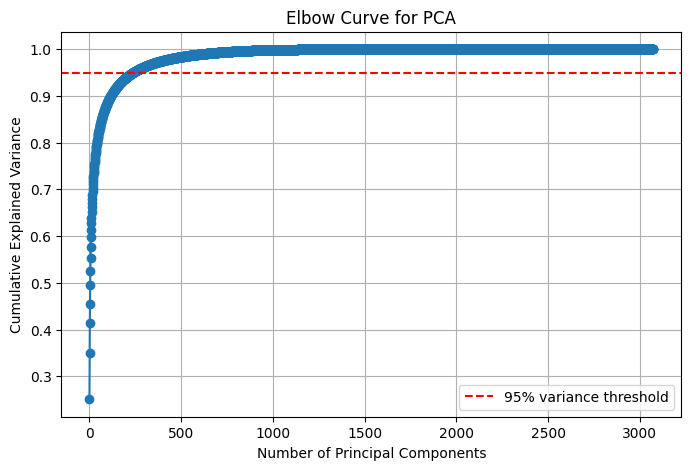

In [ ]:
#Plot elbow curve to see cumulative explained variance in correlation with components
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumsum) + 1), cumsum, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Curve for PCA')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance threshold')
plt.legend()
plt.show()

In [ ]:
#Initiate pca with pre-defined d
pca = PCA(n_components=d)

#Fit PCA using (clean) training data
start_timePCA = time.time()
pca.fit(pca_train_images_flat)
end_timePCA = time.time()
timePCA = end_timePCA - start_timePCA

#Transform adversarial data into lower-dimensional principal component space
images_adv_pca = pca.transform(pca_adversarial_images_flat)

#Apply pca to adversarial images to use as input for CNN
imgs_pca_reconstructed_flat = pca.inverse_transform(images_adv_pca) #reconstruct images back to original space
imgs_pca_reconstructed = imgs_pca_reconstructed_flat.reshape(-1, height, width, color) #reshapes back into original dimensions (height, width, channels)

In [ ]:
#Evaluate CNN with pca-preprocessed adversarial test images
performance_pca = model6.evaluate(imgs_pca_reconstructed, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5699 - loss: 1.7768


**Takeaway**: accuracy could not be improved compared to the CNN model predicting without defense mechanism, it even get worse

## Simple Autoencoder
**Structure**: Encoder and decoder consisting of flat and dense layer that reduces the images to a latent dimension of 64

In [ ]:
#Build simple autoencoder
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape

    #Encoder
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])

    #Decoder
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = test_images.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [ ]:
#Compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
#Train the autoencoder
start_timeAE1 = time.time()
autoencoder.fit(train_images, train_images, #input: (clean) train images, output: (clean) train images
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(val_images, val_images))
end_timeAE1 = time.time()
timeAE1 = end_timeAE1 - start_timeAE1

Epoch 1/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6341 - val_loss: 0.6111
Epoch 2/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6069 - val_loss: 0.6008
Epoch 3/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6021 - val_loss: 0.6004
Epoch 4/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6008 - val_loss: 0.5997
Epoch 5/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6008 - val_loss: 0.5998
Epoch 6/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6009 - val_loss: 0.5996
Epoch 7/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6007 - val_loss: 0.5994
Epoch 8/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6007 - val_loss: 0.5998
Epoch 9/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6005 - val_loss: 0.5994
Epoch 10/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6007 - val_loss: 0.5997


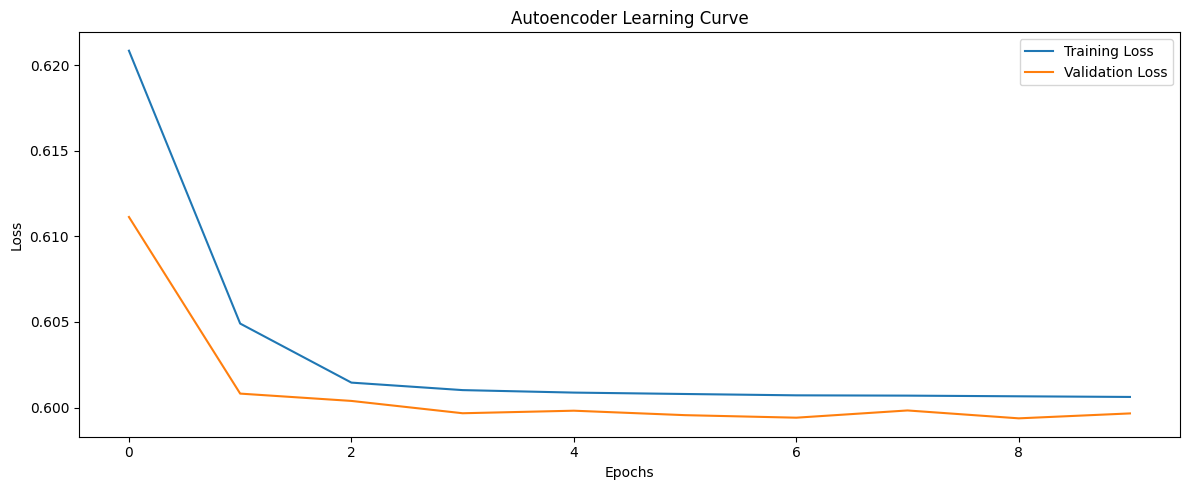

In [ ]:
#Plot learning curves for the autoencoder
plt.figure(figsize=(12, 5))

#Loss plot
plt.plot(autoencoder.history.history['loss'], label='Training Loss')
plt.plot(autoencoder.history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Takeaway**: looking at the learning curve, the loss is very high --> suggesting that this simple autoencoder might not be very suitable for the data

In [ ]:
#Apply trained autoencoder on adversarial images (encode&decode)
encoded_imgs_ae1 = autoencoder.encoder(adversarial_test_images).numpy()
decoded_imgs_ae1 = autoencoder.decoder(encoded_imgs_ae1).numpy()

In [ ]:
#Apply CNN on adversarial images that are encoded & decoded
performance_autoencoder1=model6.evaluate(decoded_imgs_ae1, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6045 - loss: 1.1527


**Takeaway**: Using a simple autoencoder that is trained on the training data (not noisy) does not help restoring the model performance when data is FGSM perturbed with epsilon = 0.01 (actually making it worse). Also from the validation and training loss, the simple autoencoder does not seem to fit the data very well.

## Convolutional Autoencoder
**Structure**: Convolutional encoder with two layers (16 and 8 filters), kernel size: 3,3

Convolutional decoder using transposed convolutions, ending with a 3-channel output layer
-> trained on clean data


*Changes to previous model:* Convolutional aspect


In [ ]:
#Build convolutional autoencoder model
class SimpleDenoise(tf.keras.Model):
  def __init__(self):
    super(SimpleDenoise, self).__init__()

    #Encoder
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 32, 3)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)])

    #Decoder
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, (3, 3), strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, (3, 3), strides=1, activation='relu', padding='same'),
      layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')])

  #Forward pass, encode input image and then decode it back
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
#Instantiate model
autoencoder2 = SimpleDenoise()

In [ ]:
#Compile autoencoder
autoencoder2.compile(optimizer='adam', loss='mse')

In [ ]:
#Fit convolutional autoencoder
start_timeAE2 = time.time()
autoencoder2.fit(train_images, train_images, #input: (clean) train images, output: (clean) train images
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(val_images, val_images))
end_timeAE2 = time.time()
timeAE2 = end_timeAE2 - start_timeAE2

Epoch 1/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0088 - val_loss: 7.7088e-04
Epoch 2/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6.0623e-04 - val_loss: 4.4044e-04
Epoch 3/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.4709e-04 - val_loss: 3.6485e-04
Epoch 4/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.7992e-04 - val_loss: 3.6693e-04
Epoch 5/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.5418e-04 - val_loss: 4.6275e-04
Epoch 6/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.2017e-04 - val_loss: 2.9702e-04
Epoch 7/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.9559e-04 - val_loss: 4.1542e-04
Epoch 8/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.7661e-04 - val_loss: 2.9387e-04
Epoch 9/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.6759e-04 - val_loss: 2.4067e-04
Epoch 10/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.4868e-04 - val_loss: 2.2899e-04


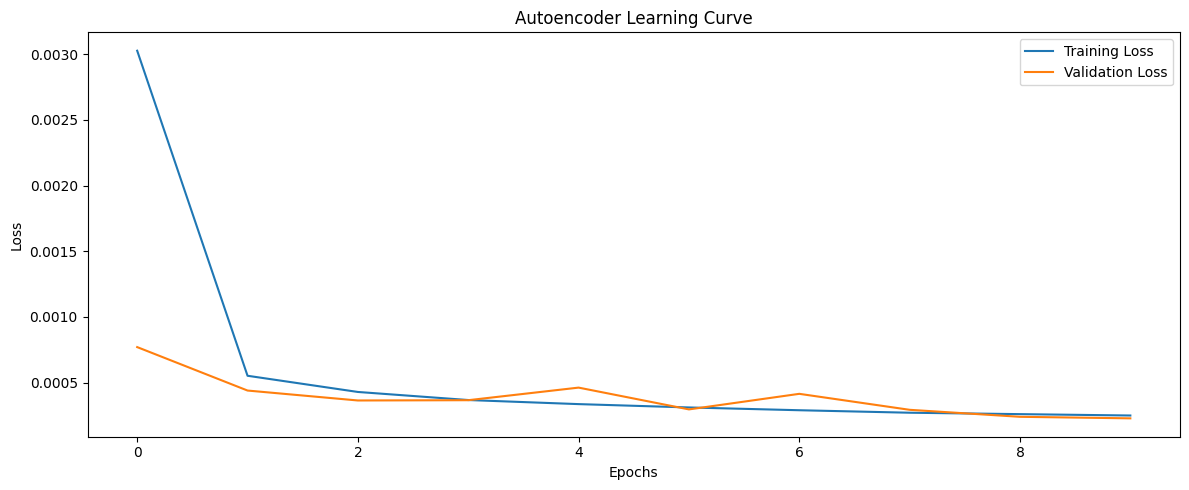

In [ ]:
#Plot learning curves for the autoencoder
plt.figure(figsize=(12, 5))

#Loss plot
plt.plot(autoencoder2.history.history['loss'], label='Training Loss')
plt.plot(autoencoder2.history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Apply trained autoencoder on adversarial images (encode&decode)
encoded_imgs_ae2 = autoencoder2.encoder(adversarial_test_images).numpy()
decoded_imgs_ae2 = autoencoder2.decoder(encoded_imgs_ae2).numpy()

In [ ]:
#Check model performance on adversarial images with conv. autoencoder
performance_autoencoder2 = model6.evaluate(decoded_imgs_ae2, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6967 - loss: 0.8598


**Takeaway**: Increased performance through convolutional structure.

## Denoising Autoencoder 1
**Structure**: Convolutional encoder with two layers (16 and 8 filters); Convolutional decoder using transposed convolutions, ending with a 3-channel output layer


*Changes to previous model:* **trained on adversarial images** as input and (clean) test images as targeted output


In [ ]:
#Define and compile the denoising model
autoencoder3 = SimpleDenoise()
autoencoder3.compile(optimizer='adam', loss='mse')

In [ ]:
#Fit first denoising autoencoder
start_timeAE3 = time.time()
autoencoder3.fit(
    adversarial_train_images, train_images, #input: adverdsarial images, output: (clean) train images
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(adversarial_val_images , val_images))
end_timeAE3 = time.time()
timeAE3 = end_timeAE3 - start_timeAE3

Epoch 1/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0072 - val_loss: 7.9546e-04
Epoch 2/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 7.8047e-04 - val_loss: 6.3748e-04
Epoch 3/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6.6020e-04 - val_loss: 5.5355e-04
Epoch 4/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.9233e-04 - val_loss: 5.1786e-04
Epoch 5/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.5723e-04 - val_loss: 5.0128e-04
Epoch 6/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.3739e-04 - val_loss: 5.5743e-04
Epoch 7/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.1836e-04 - val_loss: 4.8152e-04
Epoch 8/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.1194e-04 - val_loss: 4.9936e-04
Epoch 9/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.9276e-04 - val_loss: 5.2902e-04
Epoch 10/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.8807e-04 - val_loss: 4.8782e-04


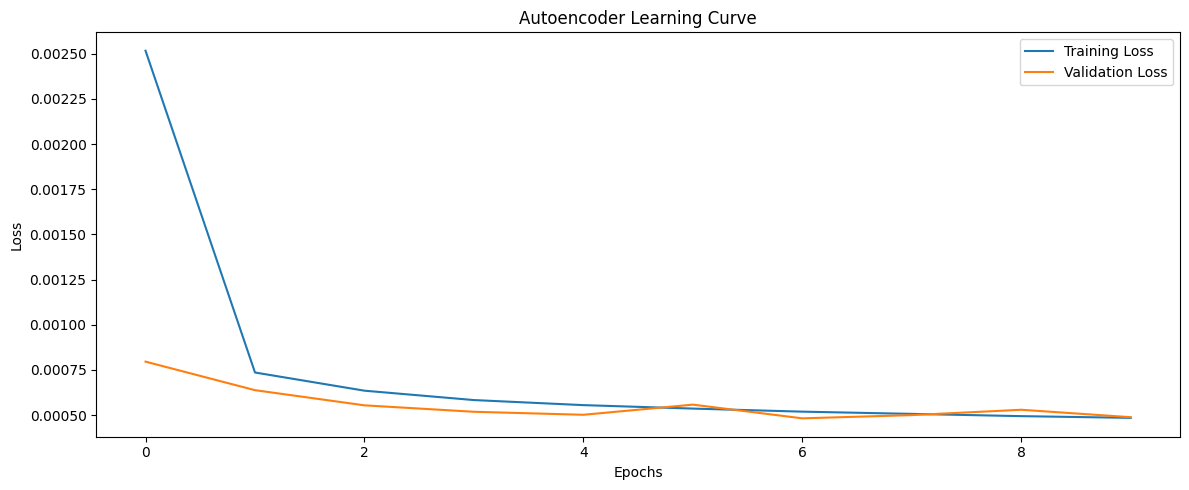

In [ ]:
#Plot learning curve
plt.figure(figsize=(12, 5))
plt.plot(autoencoder3.history.history['loss'], label='Training Loss')
plt.plot(autoencoder3.history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Apply trained autoencoder on adversarial images (encode&decode)
encoded_imgs_ae3 = autoencoder3.encoder(adversarial_test_images)
decoded_imgs_ae3 = autoencoder3.decoder(encoded_imgs_ae3).numpy()


In [ ]:
#Check model performance on adversarial images with den. autoencoder
performance_autoencoder3 = model6.evaluate(decoded_imgs_ae3, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7182 - loss: 0.8034


**Takeaway**: Improvement of accuracy, however upward potential to capture

## Denoising autoencoder 2
**Structure**: Convolutional encoder with four layers (64,32,16 and 8 filters); Convolutional decoder using transposed convolutions, ending with a 3-channel output layer, trained on adversarial images as input and (clean) test images as targeted output.


*Changes to previous model:* Two additional convolutional layers

In [ ]:
#More sophisticaed autoencoder, trained on adversarial data
class Denoise2(tf.keras.Model):
  def __init__(self):
    super(Denoise2, self).__init__()
    #Encoder
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 32, 3)),
      layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=1), #added layer
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)])

    #Decoder
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=1, activation='relu', padding='same'), #added layer
      layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  #Forward pass, encode input image and then decode it back
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

#Instantiate model
autoencoder4 = Denoise2()

In [ ]:
#Compile model
autoencoder4.compile(optimizer='adam', loss='mse')

In [ ]:
#Fit second denoising autonecoder
start_timeAE4 = time.time()
autoencoder4.fit(adversarial_train_images, train_images, #input: adverdsarial images, output: (clean) train images
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(adversarial_val_images, val_images))
end_timeAE4 = time.time()
timeAE4 = end_timeAE4 - start_timeAE4

Epoch 1/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 2/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 4.3858e-04 - val_loss: 4.1388e-04
Epoch 3/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 3.1107e-04 - val_loss: 3.8002e-04
Epoch 4/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 2.6043e-04 - val_loss: 2.8205e-04
Epoch 5/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 2.2350e-04 - val_loss: 1.5827e-04
Epoch 6/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 2.0018e-04 - val_loss: 2.5697e-04
Epoch 7/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1.8932e-04 - val_loss: 1.7568e-04
Epoch 8/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1.7771e-04 - val_loss: 1.1569e-04
Epoch 9/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1.7758e-04 - val_loss: 1.5090e-04
Epoch 10/10
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1.6260e-04 - val_loss: 1.2299e-04


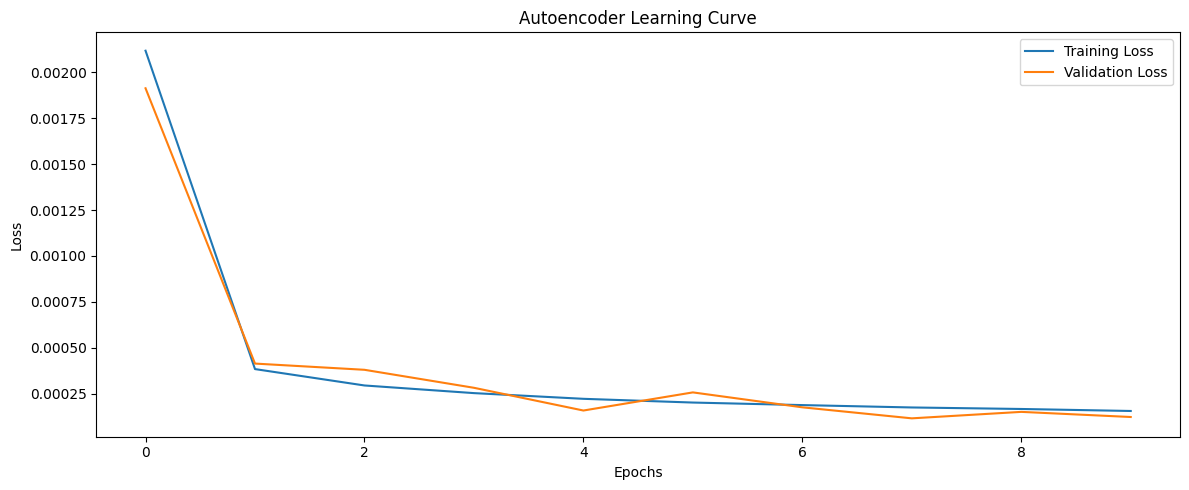

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.plot(autoencoder4.history.history['loss'], label='Training Loss')
plt.plot(autoencoder4.history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Apply trained autoencoder on adversarial images to see whether this improves CNN performance

#Initiate lists  with encoded and decoded images
encoded_imgs_ae4_list = []
decoded_imgs_ae4_list = []

for i in range(0, len(adversarial_test_images), 32):
    batch = adversarial_test_images[i:i+32] #take index i +32 images per batch

    #Encode and decode the batch
    encoded_batch = autoencoder4.encoder(batch).numpy()
    decoded_batch = autoencoder4.decoder(encoded_batch).numpy()

    #Append the results to the lists
    encoded_imgs_ae4_list.extend(encoded_batch)
    decoded_imgs_ae4_list.extend(decoded_batch)

#Convert the lists to numpy arrays
encoded_imgs_ae4 = np.array(encoded_imgs_ae4_list)
decoded_imgs_ae4 = np.array(decoded_imgs_ae4_list)

In [ ]:
#Check model performance on adversarial images with den. autoencoder2
performance_autoencoder4 = model6.evaluate(decoded_imgs_ae4, test_labels)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7471 - loss: 0.7367


**Takeaway**: Increased performance by another 2% through deeper structure with more layers

## Comparison of Performance per Defense Mechanism

In [ ]:
#Compare accuracy & recall per Defense Mechanism (& benchmark against baseline performance wwithout defence)
#Get baseline performance with clean images
optimized_model_accuracy=accuracy_score(test_labels, y_pred_6)
#Get baseline performance with adversarial iamges
y_pred_baseline = model6.predict(adversarial_test_images)
y_predbaseline = (y_pred_baseline > 0.5).astype("int32")
recallbaseline = recall_score(test_labels, y_predbaseline)
accuracybaseline = accuracy_score(test_labels, y_predbaseline )
#Get predicted probabilities
y_pred_pca = model6.predict(imgs_pca_reconstructed)
y_predpca = (y_pred_pca > 0.5).astype("int32")
recallpca = recall_score(test_labels, y_predpca)
accuracypca = accuracy_score(test_labels, y_predpca )
#Get predicted probabilities
y_pred_ae1 = model6.predict(decoded_imgs_ae1)
y_predae1 = (y_pred_ae1 > 0.5).astype("int32")
recallae1 = recall_score(test_labels, y_predae1 )
accuracyae1 = accuracy_score(test_labels, y_predae1)
#Get predicted probabilities
y_pred_ae2 = model6.predict(decoded_imgs_ae2)
y_predae2 = (y_pred_ae2 > 0.5).astype("int32")
recallae2 = recall_score(test_labels, y_predae2)
accuracyae2 = accuracy_score(test_labels, y_predae2)
#Get predicted probabipredict
y_pred_ae3 = model6.predict(decoded_imgs_ae3)
y_predae3 = (y_pred_ae3 > 0.5).astype("int32")
recallae3 = recall_score(test_labels, y_predae3)
accuracyae3 = accuracy_score(test_labels, y_predae3)
#Get predicted probabilities
y_pred_ae4 = model6.predict(decoded_imgs_ae4)
y_predae4 = (y_pred_ae4 > 0.5).astype("int32")
recallae4 = recall_score(test_labels, y_predae4)
accuracyae4 = accuracy_score(test_labels, y_predae4)

1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1113/1113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


### Accuracy

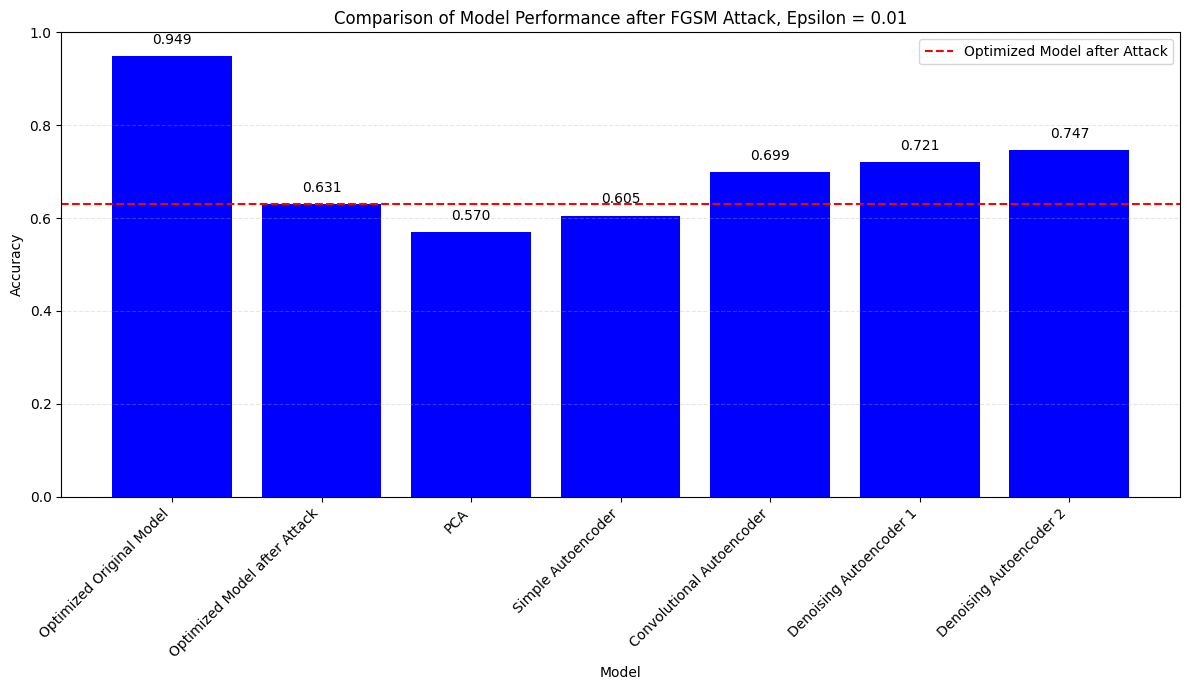

In [ ]:
#Create a bar chart to compare the accuracies
labels = ['Optimized Original Model', 'Optimized Model after Attack', 'PCA', 'Simple Autoencoder', 'Convolutional Autoencoder', 'Denoising Autoencoder 1', 'Denoising Autoencoder 2' ]
accuracies = [optimized_model_accuracy, accuracybaseline, accuracypca, accuracyae1, accuracyae2, accuracyae3, accuracyae4
]

plt.figure(figsize=(12, 7))
bars = plt.bar(labels, accuracies, color=['blue'])
plt.ylim(0, 1)
plt.title('Comparison of Model Performance after FGSM Attack, Epsilon = 0.01')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.3)

#Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.axhline(y=accuracybaseline, color='red', linestyle='--', label='Optimized Model after Attack') #add benchmarking line
plt.legend()

#Add accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, accuracy + 0.02,
             f'{accuracy:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
#Define recall values (accuracy and labels can be taken from above)
recalls = [
    cnn6_recall,
    recallbaseline,
    recallpca,
    recallae1,
    recallae2,
    recallae3,
    recallae4
]

#Build pretty table data
table_data = []
for label, acc, rec in zip(labels, accuracies, recalls):
    acc_str = f"{acc:.4f}"
    rec_str = f"{rec:.4f}" if rec is not None else "-"
    table_data.append([label, acc_str, rec_str])

#Print table
headers = ["Model", "Accuracy", "Recall"]
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


╒══════════════════════════════╤════════════╤══════════╕
│ Model                        │   Accuracy │   Recall │
╞══════════════════════════════╪════════════╪══════════╡
│ Optimized Original Model     │     0.9486 │   0.9335 │
├──────────────────────────────┼────────────┼──────────┤
│ Optimized Model after Attack │     0.6305 │   0.5619 │
├──────────────────────────────┼────────────┼──────────┤
│ PCA                          │     0.5699 │   0.132  │
├──────────────────────────────┼────────────┼──────────┤
│ Simple Autoencoder           │     0.6055 │   0.3473 │
├──────────────────────────────┼────────────┼──────────┤
│ Convolutional Autoencoder    │     0.699  │   0.6289 │
├──────────────────────────────┼────────────┼──────────┤
│ Denoising Autoencoder 1      │     0.7208 │   0.6494 │
├──────────────────────────────┼────────────┼──────────┤
│ Denoising Autoencoder 2      │     0.7469 │   0.7134 │
╘══════════════════════════════╧════════════╧══════════╛


## Comparison of Reconstructed images

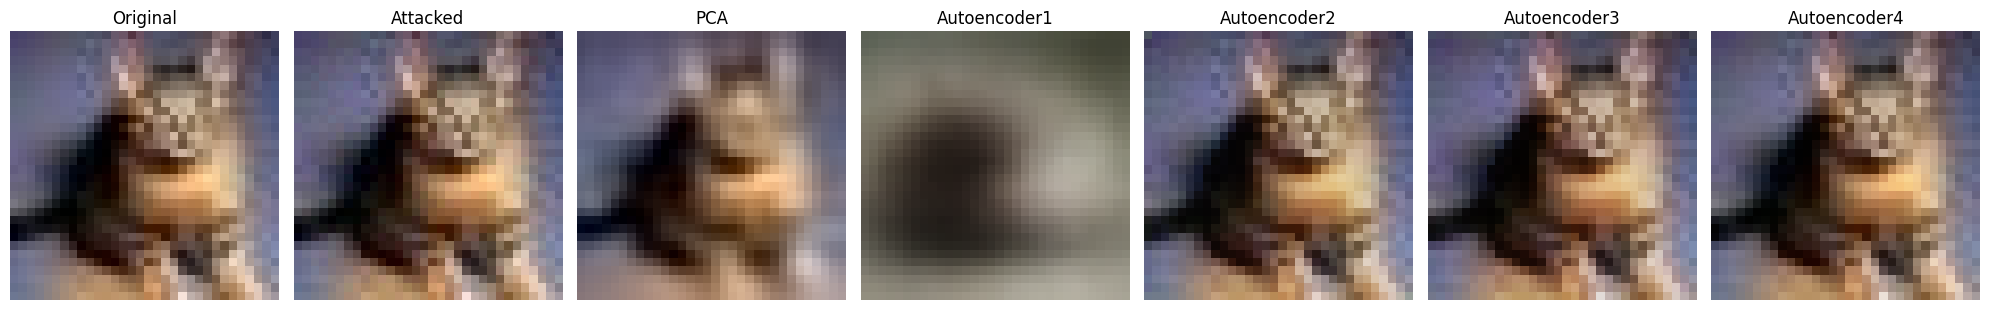

In [ ]:
#Depict reconstructed images per defense mechanism
reconstructed_images = {
    "Original": test_images[2],
    "Attacked": adversarial_test_images[2],
    "PCA": imgs_pca_reconstructed[2],
    "Autoencoder1": decoded_imgs_ae1[2],
    "Autoencoder2": decoded_imgs_ae2[2],
    "Autoencoder3": decoded_imgs_ae3[2],
    "Autoencoder4": decoded_imgs_ae4[2],
}

plt.figure(figsize=(20, 4))

for index, (title, image) in enumerate(reconstructed_images.items()):
    ax = plt.subplot(1, len(reconstructed_images), index + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Comparison of Running Time: Model and Defense Mechanisms



In [ ]:
#Divide Running time by 60 to get minute values
cnn_timem=cnn_time/60
timePCAm=timePCA/60
timeAE1m=timeAE1/60
timeAE2m=timeAE2/60
timeAE3m=timeAE3/60
timeAE4m=timeAE4/60

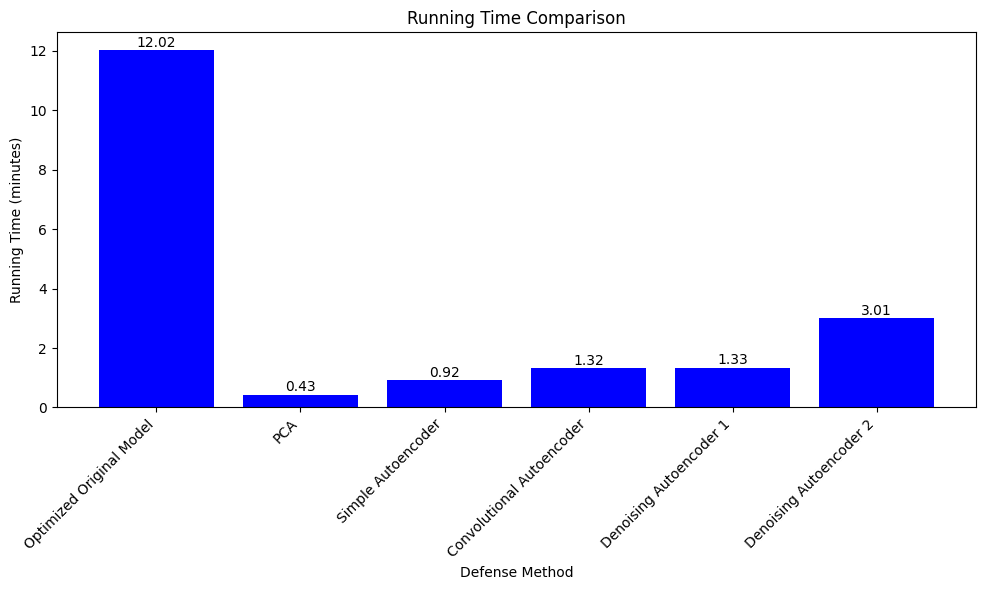

In [ ]:
#Plot running times of training per model

#Create lists for labels and running times
labels2 = ['Optimized Original Model', 'PCA', 'Simple Autoencoder', 'Convolutional Autoencoder', 'Denoising Autoencoder 1', 'Denoising Autoencoder 2' ]
running_times = [cnn_timem, timePCAm, timeAE1m, timeAE2m, timeAE3m, timeAE4m]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels2, running_times, color=['blue'])
plt.title('Running Time Comparison')
plt.xlabel('Defense Method')
plt.ylabel('Running Time (minutes)')
plt.xticks(rotation=45, ha='right')

# Add values on top of the bars
for bar, running_time in zip(bars, running_times):
    plt.text(bar.get_x() + bar.get_width() / 2, running_time + 0.02,
             f'{running_time:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()